<a href="https://colab.research.google.com/github/poulamimukherjee25m-stack/CNN_CIFAR100/blob/main/CNN_CIFAR100_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 15.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchmetrics

# Set batch size
batch_size = 128

In [3]:
# Define data transformations
# CIFAR-100 images are 32x32 RGB images

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])



Loading CIFAR-100 dataset...


100%|██████████| 169M/169M [00:01<00:00, 96.2MB/s]


Training samples: 50000
Test samples: 10000
Number of classes: 100

Sample batch - Images shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128])

Displaying sample training images...


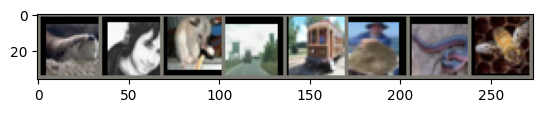

In [4]:
# Load CIFAR-100 dataset
print("Loading CIFAR-100 dataset...")
train_dataset = datasets.CIFAR100(root="dataset/", download=True, train=True, transform=transform_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.CIFAR100(root="dataset/", download=True, train=False, transform=transform_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: 100")

# Function to display images
def imshow(img):
    """Display image tensor"""
    # Denormalize for visualization
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"\nSample batch - Images shape: {images.shape}, Labels shape: {labels.shape}")

# Show images
print("\nDisplaying sample training images...")
imshow(torchvision.utils.make_grid(images[:8]))

In [5]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        """
        Building blocks of convolutional neural network for CIFAR-100.
        Parameters:
            * in_channels: Number of channels in the input image (for RGB images, 3)
            * num_classes: Number of classes to predict. In CIFAR-100, 100 classes.
        """
        super(CNN, self).__init__()
        # 1st convolutional layer
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 2nd convolutional layer
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        # 3rd convolutional layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # 4th convolutional layer
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # 5th convolutional layer
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Fully connected layer
        # After four max pooling operations: 32x32 -> 16x16 -> 8x8 -> 4x4 -> 2x2
        # So the flattened size is: 128 channels * 2 * 2 = 512
        self.fc1 = nn.Linear(128 * 2 * 2, num_classes)

    def forward(self, x):
        """
        Define the forward pass of the neural network.
        Parameters:
            x: Input tensor.
        Returns:
            torch.Tensor
                The output tensor after passing through the network.
        """
        x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
        x = self.pool(x)           # Apply first max pooling (32x32 -> 16x16)
        x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
        x = self.pool(x)           # Apply second max pooling (16x16 -> 8x8)
        x = F.relu(self.conv3(x))  # Apply third convolution and ReLU activation
        x = self.pool(x)           # Apply third max pooling (8x8 -> 4x4)
        x = F.relu(self.conv4(x))  # Apply fourth convolution and ReLU activation
        x = self.pool(x)           # Apply fourth max pooling (4x4 -> 2x2)
        x = F.relu(self.conv5(x))  # Apply fifth convolution and ReLU activation
        x = x.reshape(x.shape[0], -1)  # Flatten the tensor
        x = self.fc1(x)            # Apply fully connected layer
        return x

In [6]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device: {device}")

# Create model
model = CNN(in_channels=3,num_classes=100).to(device)
print("\nModel architecture:")
print(model)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device: {device}")

# Create model
model = CNN(in_channels=3, num_classes=100).to(device)
print("\nModel architecture:")
print(model)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
print(f"\nStarting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch + 1}/{num_epochs}]")
    model.train()  # Set model to training mode
    running_loss = 0.0

    for batch_index, (data, targets) in enumerate(tqdm(train_loader, desc="Training")):
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Average training loss: {avg_loss:.4f}")

print("\nTraining completed!")



Using device: cpu

Model architecture:
CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=100, bias=True)
)

Using device: cpu

Model architecture:
CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padd

Training: 100%|██████████| 391/391 [00:49<00:00,  7.97it/s]


Average training loss: 4.0922

Epoch [2/100]


Training: 100%|██████████| 391/391 [00:49<00:00,  7.96it/s]


Average training loss: 3.6067

Epoch [3/100]


Training: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]


Average training loss: 3.3322

Epoch [4/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.03it/s]


Average training loss: 3.1602

Epoch [5/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s]


Average training loss: 3.0396

Epoch [6/100]


Training: 100%|██████████| 391/391 [00:49<00:00,  7.96it/s]


Average training loss: 2.9264

Epoch [7/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]


Average training loss: 2.8328

Epoch [8/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.06it/s]


Average training loss: 2.7536

Epoch [9/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


Average training loss: 2.6817

Epoch [10/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.04it/s]


Average training loss: 2.6328

Epoch [11/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]


Average training loss: 2.5722

Epoch [12/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.05it/s]


Average training loss: 2.5310

Epoch [13/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s]


Average training loss: 2.4866

Epoch [14/100]


Training: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]


Average training loss: 2.4493

Epoch [15/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.02it/s]


Average training loss: 2.4152

Epoch [16/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]


Average training loss: 2.3782

Epoch [17/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  7.99it/s]


Average training loss: 2.3408

Epoch [18/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  7.99it/s]


Average training loss: 2.3032

Epoch [19/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.03it/s]


Average training loss: 2.2809

Epoch [20/100]


Training: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]


Average training loss: 2.2670

Epoch [21/100]


Training: 100%|██████████| 391/391 [00:50<00:00,  7.82it/s]


Average training loss: 2.2329

Epoch [22/100]


Training: 100%|██████████| 391/391 [00:49<00:00,  7.95it/s]


Average training loss: 2.2075

Epoch [23/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s]


Average training loss: 2.1799

Epoch [24/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s]


Average training loss: 2.1613

Epoch [25/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s]


Average training loss: 2.1405

Epoch [26/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.02it/s]


Average training loss: 2.1317

Epoch [27/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


Average training loss: 2.1049

Epoch [28/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


Average training loss: 2.0945

Epoch [29/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


Average training loss: 2.0657

Epoch [30/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


Average training loss: 2.0547

Epoch [31/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]


Average training loss: 2.0346

Epoch [32/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


Average training loss: 2.0233

Epoch [33/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.12it/s]


Average training loss: 2.0145

Epoch [34/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]


Average training loss: 1.9985

Epoch [35/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


Average training loss: 1.9848

Epoch [36/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.11it/s]


Average training loss: 1.9809

Epoch [37/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.12it/s]


Average training loss: 1.9592

Epoch [38/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.05it/s]


Average training loss: 1.9472

Epoch [39/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s]


Average training loss: 1.9394

Epoch [40/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.04it/s]


Average training loss: 1.9366

Epoch [41/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]


Average training loss: 1.9278

Epoch [42/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]


Average training loss: 1.9070

Epoch [43/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s]


Average training loss: 1.8941

Epoch [44/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s]


Average training loss: 1.8964

Epoch [45/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]


Average training loss: 1.8783

Epoch [46/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]


Average training loss: 1.8748

Epoch [47/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]


Average training loss: 1.8634

Epoch [48/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


Average training loss: 1.8505

Epoch [49/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


Average training loss: 1.8447

Epoch [50/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


Average training loss: 1.8328

Epoch [51/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]


Average training loss: 1.8347

Epoch [52/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.12it/s]


Average training loss: 1.8349

Epoch [53/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]


Average training loss: 1.8227

Epoch [54/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]


Average training loss: 1.8177

Epoch [55/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s]


Average training loss: 1.8007

Epoch [56/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


Average training loss: 1.7996

Epoch [57/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.11it/s]


Average training loss: 1.7875

Epoch [58/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.05it/s]


Average training loss: 1.7909

Epoch [59/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  7.99it/s]


Average training loss: 1.7842

Epoch [60/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


Average training loss: 1.7688

Epoch [61/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


Average training loss: 1.7692

Epoch [62/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]


Average training loss: 1.7696

Epoch [63/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


Average training loss: 1.7647

Epoch [64/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


Average training loss: 1.7634

Epoch [65/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


Average training loss: 1.7398

Epoch [66/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]


Average training loss: 1.7493

Epoch [67/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]


Average training loss: 1.7357

Epoch [68/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


Average training loss: 1.7406

Epoch [69/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


Average training loss: 1.7424

Epoch [70/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


Average training loss: 1.7214

Epoch [71/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


Average training loss: 1.7213

Epoch [72/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]


Average training loss: 1.7213

Epoch [73/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


Average training loss: 1.7124

Epoch [74/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


Average training loss: 1.7147

Epoch [75/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]


Average training loss: 1.7057

Epoch [76/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


Average training loss: 1.7004

Epoch [77/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.04it/s]


Average training loss: 1.7021

Epoch [78/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.12it/s]


Average training loss: 1.6983

Epoch [79/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]


Average training loss: 1.6991

Epoch [80/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


Average training loss: 1.6850

Epoch [81/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]


Average training loss: 1.6806

Epoch [82/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


Average training loss: 1.6682

Epoch [83/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


Average training loss: 1.6715

Epoch [84/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


Average training loss: 1.6669

Epoch [85/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]


Average training loss: 1.6655

Epoch [86/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]


Average training loss: 1.6730

Epoch [87/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


Average training loss: 1.6614

Epoch [88/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


Average training loss: 1.6549

Epoch [89/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]


Average training loss: 1.6509

Epoch [90/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


Average training loss: 1.6571

Epoch [91/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


Average training loss: 1.6549

Epoch [92/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]


Average training loss: 1.6477

Epoch [93/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


Average training loss: 1.6462

Epoch [94/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


Average training loss: 1.6344

Epoch [95/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.12it/s]


Average training loss: 1.6445

Epoch [96/100]


Training: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


Average training loss: 1.6302

Epoch [97/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]


Average training loss: 1.6375

Epoch [98/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]


Average training loss: 1.6319

Epoch [99/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


Average training loss: 1.6319

Epoch [100/100]


Training: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]

Average training loss: 1.6299

Training completed!


In [7]:
# Evaluation
print("\nEvaluating on test set...")

# Set up multiclass accuracy metric
acc = torchmetrics.Accuracy(task="multiclass", num_classes=100)
precision = torchmetrics.Precision(task="multiclass", num_classes=100, average='macro')
recall = torchmetrics.Recall(task="multiclass", num_classes=100, average='macro')

# Iterate over the test dataset batches
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)

        # Get predicted probabilities for test data batch
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Update metrics
        acc(preds.cpu(), labels.cpu())
        precision(preds.cpu(), labels.cpu())
        recall(preds.cpu(), labels.cpu())

# Compute total test metrics
test_accuracy = acc.compute()
test_precision = precision.compute()
test_recall = recall.compute()

print(f"\nTest Results:")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Test Precision: {test_precision:.4f}")
print(f"  Test Recall: {test_recall:.4f}")

print("\n" + "="*80)
print("CNN Training and Evaluation Complete!")
print("="*80)



Evaluating on test set...


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]


Test Results:
  Test Accuracy: 0.4108 (41.08%)
  Test Precision: 0.4131
  Test Recall: 0.4108

CNN Training and Evaluation Complete!
